In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU, AUC

import warnings
warnings.filterwarnings("ignore")

Download the latest version of [A Large Scale Fish Dataset](https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset)

In [ ]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

#print("Path to dataset files:", path)

100%|██████████| 3.24G/3.24G [00:31<00:00, 112MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2


In [2]:
data_path = "./content/train"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
classes = [i for i in os.listdir(data_path) if '.' not in i]
classes

['Merisiig', 'Siirdesiig']

In [19]:
# train_df
label = []
path = []

for dirname, _,filenames in os.walk(data_path):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png' or os.path.splitext(filename)[-1]=='.jpg':
            if dirname.split()[-1]!='GT':
                label.append(os.path.split(dirname)[-1])
                path.append(os.path.join(dirname,filename))

train_df = pd.DataFrame(columns=['path','label'])
train_df['path']=path
train_df['label']=label

In [20]:
# test_df
test_data_path = "./content/test"
label = []
path = []

for dirname, _,filenames in os.walk(test_data_path):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png' or os.path.splitext(filename)[-1]=='.jpg':
            if dirname.split()[-1]!='GT':
                label.append(os.path.split(dirname)[-1])
                path.append(os.path.join(dirname,filename))

test_df = pd.DataFrame(columns=['path','label'])
test_df['path']=path
test_df['label']=label

In [6]:
test_df.head()
train_df.head()

,path,label
0,./content/train\Merisiig\H201701_fish_1.jpg,Merisiig
1,./content/train\Merisiig\H201701_fish_1.png,Merisiig
2,./content/train\Merisiig\H201701_fish_1_cycle1...,Merisiig
3,./content/train\Merisiig\H201701_fish_1_cycle2...,Merisiig
4,./content/train\Merisiig\H201701_fish_1_cycle3...,Merisiig


In [7]:
train_df.path[0]

'./content/train\\Merisiig\\H201701_fish_1.jpg'

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    1206 non-null   object
 1   label   1206 non-null   object
dtypes: object(2)
memory usage: 19.0+ KB


In [9]:
train_df['label'].value_counts()

label
Siirdesiig    654
Merisiig      552
Name: count, dtype: int64

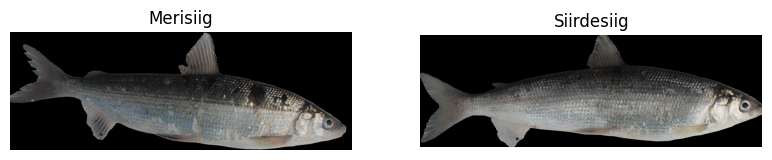

In [10]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in train_df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(train_df[train_df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

In [ ]:
# train_df, test = train_test_split(train_df, train_size=0.8, shuffle=True, random_state=42)

In [12]:
print(train_df.shape)
print(test_df.shape)

(964, 2)
(100, 2)


In [21]:
train_df, val_df = train_test_split(train_df, random_state = 111, train_size = 0.8)

In [22]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Add target_size=(224, 224) to match MobileNetV2 input requirements
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, target_size=(224, 224))
val_images = train_generator.flow_from_dataframe(dataframe=val_df, x_col='path', y_col='label', color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, target_size=(224, 224))
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False, target_size=(224, 224))


Found 964 validated image filenames belonging to 2 classes.
Found 242 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [23]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Merisiig': 0, 'Siirdesiig': 1}

{'Merisiig': 0, 'Siirdesiig': 1}

{'Merisiig': 0, 'Siirdesiig': 1}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


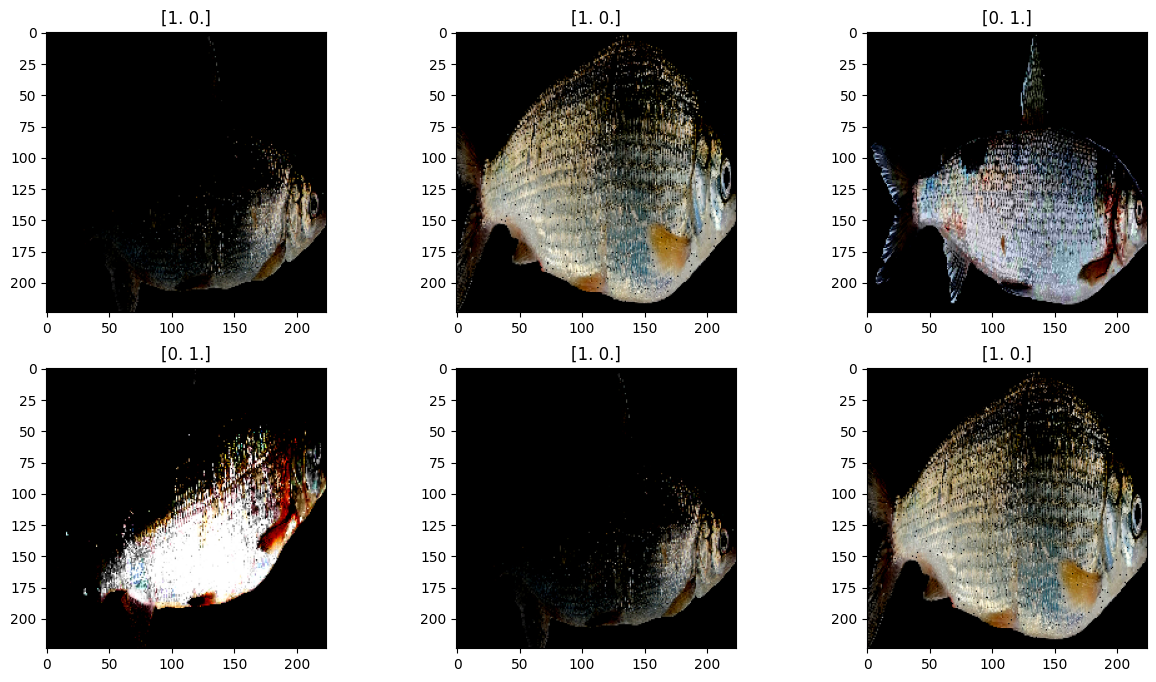

In [24]:
fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = next(test_images)
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    j=j+1

In [25]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
# pretrained_model = tf.keras.applications.MobileNetV2(
#     include_top=True,
#     weights='imagenet',
#     pooling='avg'
# )

# pretrained_model.trainable = False

In [26]:
# Fix the model architecture - use pretrained_model.input consistently
inputs = pretrained_model.input

x = tf.keras.layers.Dense(64, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,344,258 (8.94 MB)

 Trainable params: 86,274 (337.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5965 - loss: 0.7215 - val_accuracy: 0.8223 - val_loss: 0.5294
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7365 - loss: 0.5026 - val_accuracy: 0.8388 - val_loss: 0.3813
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7925 - loss: 0.4436 - val_accuracy: 0.8760 - val_loss: 0.3356
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8361 - loss: 0.3915 - val_accuracy: 0.8843 - val_loss: 0.3020
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8641 - loss: 0.3425 - val_accuracy: 0.8926 - val_loss: 0.2742
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8745 - loss: 0.3341 - val_accuracy: 0.9008 - val_loss: 0.2646
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8973 - loss: 0.2812 - val_accuracy: 0.9091 - val_loss: 0.2313
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8963 - loss: 0.2667 - val_accuracy: 0.9091 - val_loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step 
Class labels: ['Merisiig', 'Siirdesiig']
Class indices: {'Merisiig': 0, 'Siirdesiig': 1}


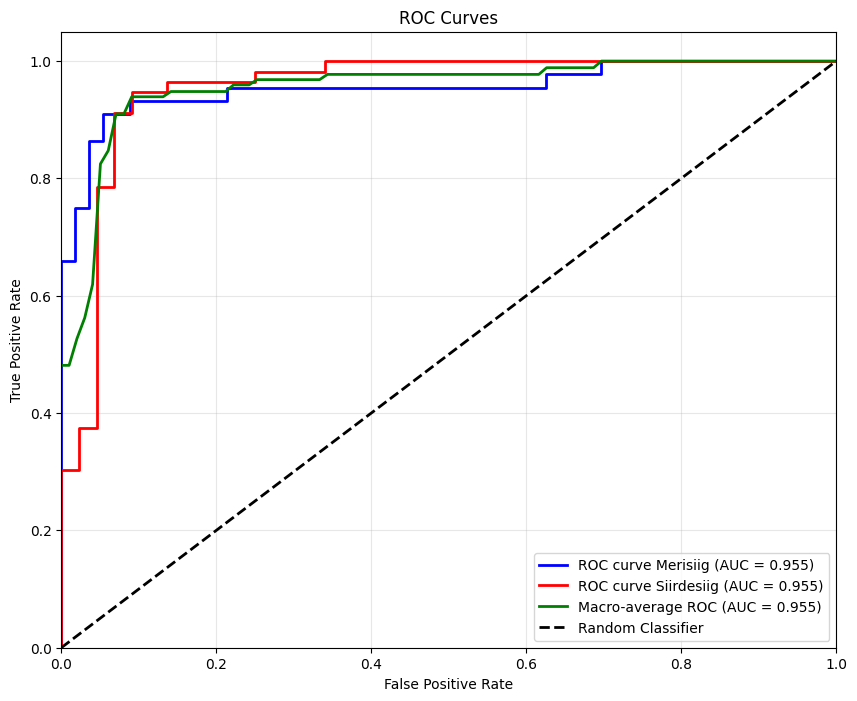


=== AUC Scores ===
Merisiig: 0.9550
Siirdesiig: 0.9550
Macro-average AUC: 0.9554
Weighted AUC: 0.9550


In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Reset test generator to get all predictions
test_images.reset()

# Get predictions on test set
y_pred_proba = model.predict(test_images)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_true = test_images.classes

# Get class labels
class_labels = list(test_images.class_indices.keys())
print(f"Class labels: {class_labels}")
print(f"Class indices: {test_images.class_indices}")

# Calculate ROC curve and AUC for each class (One-vs-Rest)
fpr = {}
tpr = {}
roc_auc = {}

# For binary classification, create one-hot encoding properly
y_true_bin = np.eye(2)[y_true]  # Convert to one-hot encoding

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate macro-average ROC curve
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(2):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 2
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red']
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve {class_labels[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot(fpr_macro, tpr_macro, 'green', lw=2,
         label=f'Macro-average ROC (AUC = {roc_auc_macro:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Print AUC scores
print("\n=== AUC Scores ===")
for i in range(2):
    print(f"{class_labels[i]}: {roc_auc[i]:.4f}")
print(f"Macro-average AUC: {roc_auc_macro:.4f}")

# Calculate overall AUC (weighted)
overall_auc = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='weighted')
print(f"Weighted AUC: {overall_auc:.4f}")

In [28]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.34933
Test Accuracy: 93.00%


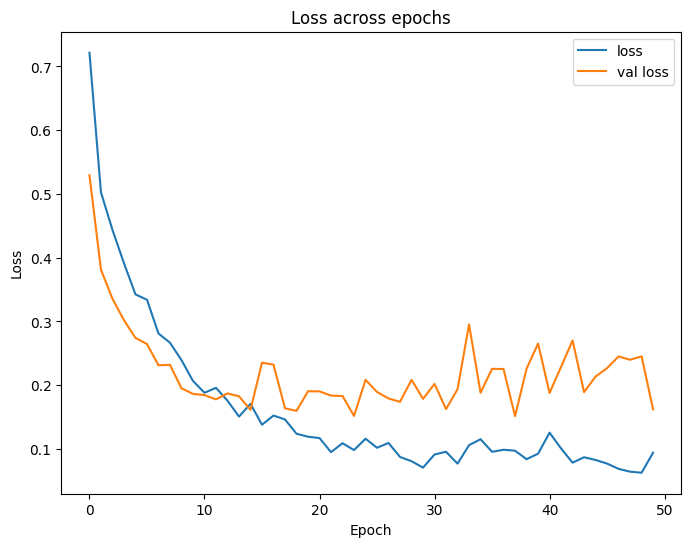

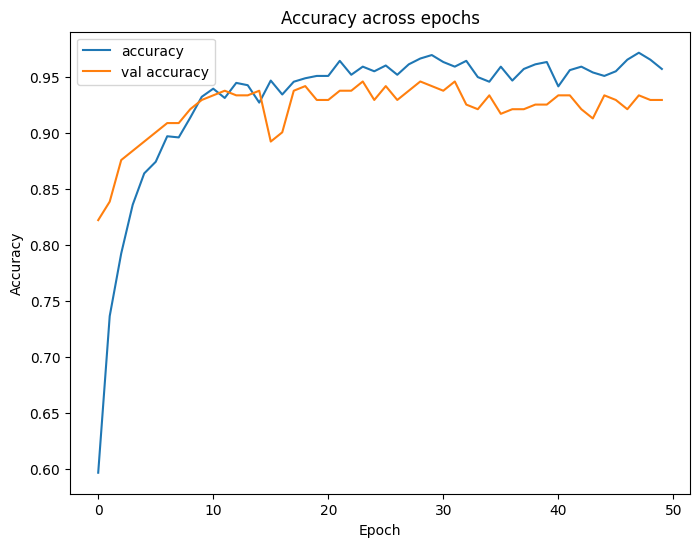

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss across epochs')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy across epochs')
plt.legend()
plt.show()

In [30]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

pred_df=pred_df.reset_index(drop=True)
pred_df.head(100)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


,path,label,pred
0,./content/test\Merisiig\H201702_fish_1.jpg,Merisiig,Merisiig
1,./content/test\Merisiig\H201702_fish_1.png,Merisiig,Merisiig
2,./content/test\Merisiig\H201703_fish_1.jpg,Merisiig,Merisiig
3,./content/test\Merisiig\H201703_fish_1.png,Merisiig,Merisiig
4,./content/test\Merisiig\H201716_fish_1.jpg,Merisiig,Merisiig
...,...,...,...
95,./content/test\Siirdesiig\Vi202006_fish_1.png,Siirdesiig,Siirdesiig
96,./content/test\Siirdesiig\Vi202018_fish_1.jpg,Siirdesiig,Siirdesiig
97,./content/test\Siirdesiig\Vi202018_fish_1.png,Siirdesiig,Siirdesiig
98,./content/test\Siirdesiig\VV202003_fish_1.jpg,Siirdesiig,Siirdesiig


In [34]:
# pred_df[pred_df['label']!=pred_df['pred']]

# pred_df.path[20]

# plt.figure(figsize=(15,8))
# plt.imshow(plt.imread(pred_df.path[20]))
# title1 = pred_df.path[20].split('/')[-2]
# title2 = pred_df.path[20].split('/')[-1]
# title3 = pred_df.pred[20]
# plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
# plt.show()

Accuracy Score: 0.93


<Axes: >

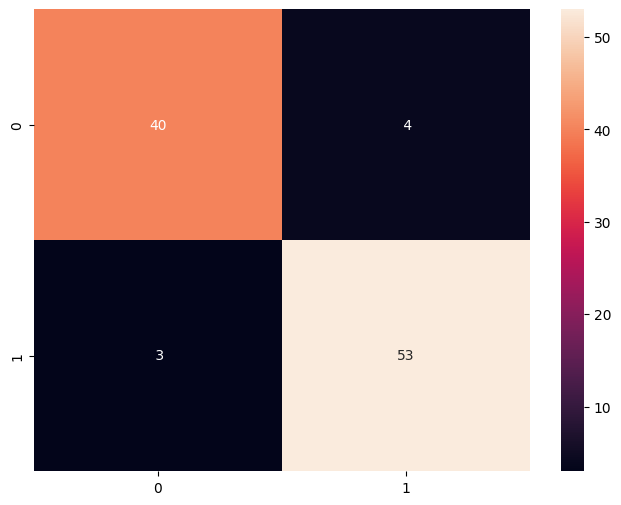

In [31]:
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

In [33]:
print(classification_report(pred_df['label'],pred_df['pred']))

              precision    recall  f1-score   support

    Merisiig       0.93      0.91      0.92        44
  Siirdesiig       0.93      0.95      0.94        56

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

